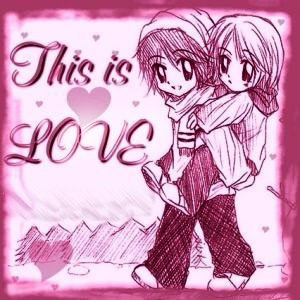

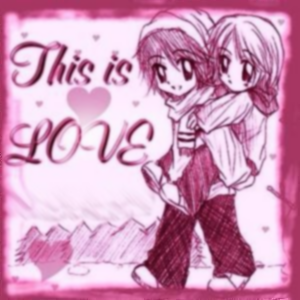

In [11]:
import cv2
from google.colab.patches import cv2_imshow
import math

def generate_gaussian_kernel(size, sigma):
    kernel = []
    sum_val = 0
    for x in range(size):
        row = []
        for y in range(size):
            val = (1 / (2 * math.pi * sigma ** 2)) * math.exp(-((x - size // 2) ** 2 + (y - size // 2) ** 2) / (2 * sigma ** 2))
            row.append(val)
            sum_val += val
        kernel.append(row)

    for x in range(size):
        for y in range(size):
            kernel[x][y] /= sum_val

    return kernel

def apply_gaussian_blur(image, kernel):
    height, width, channels = image.shape
    kernel_size = len(kernel)
    offset = kernel_size // 2
    output = image.copy()

    for i in range(offset, height - offset):
        for j in range(offset, width - offset):
            for c in range(channels):
                pixel_val = 0.0
                for ki in range(kernel_size):
                    for kj in range(kernel_size):
                        ni = i + ki - offset
                        nj = j + kj - offset
                        pixel_val += image[ni][nj][c] * kernel[ki][kj]
                output[i][j][c] = int(pixel_val)

    return output

if __name__ == "__main__":
    image = cv2.imread('unnamed.jpg')

    kernel_size = 5
    sigma = 1.0

    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)

    blurred_image = apply_gaussian_blur(image, gaussian_kernel)

    cv2.imwrite('blurred_image.jpg', blurred_image)

    cv2_imshow(image)
    cv2_imshow(blurred_image)

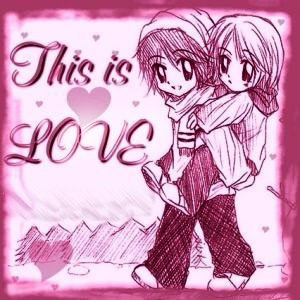

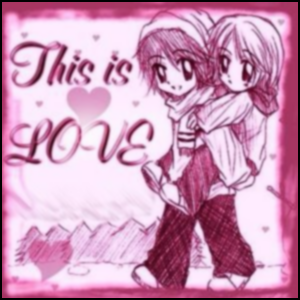

In [16]:
import cv2
import math
from numba import cuda
from google.colab.patches import cv2_imshow

def generate_gaussian_kernel(size, sigma):
    kernel = []
    sum_val = 0
    for x in range(size):
        row = []
        for y in range(size):
            val = (1 / (2 * math.pi * sigma ** 2)) * math.exp(-((x - size // 2) ** 2 + (y - size // 2) ** 2) / (2 * sigma ** 2))
            row.append(val)
            sum_val += val
        kernel.append(row)

    for x in range(size):
        for y in range(size):
            kernel[x][y] /= sum_val

    return kernel

@cuda.jit
def cuda_gaussian_blur(image, output, kernel, kernel_size, width, height, channels):
    x, y = cuda.grid(2)
    offset = kernel_size // 2

    if x >= offset and x < width - offset and y >= offset and y < height - offset:
        for c in range(channels):
            pixel_val = 0.0
            for ki in range(kernel_size):
                for kj in range(kernel_size):
                    ni = y + ki - offset
                    nj = x + kj - offset
                    pixel_val += image[ni][nj][c] * kernel[ki][kj]
            output[y][x][c] = int(pixel_val)

def image_to_list(image):
    height, width, channels = image.shape
    return [[[image[i, j, c] for c in range(channels)] for j in range(width)] for i in range(height)]

def list_to_image(image_list):
    height = len(image_list)
    width = len(image_list[0])
    channels = len(image_list[0][0])

    image = cv2.imread('unnamed.jpg')

    for i in range(height):
        for j in range(width):
            for c in range(channels):
                image[i, j, c] = image_list[i][j][c]

    return image

if __name__ == "__main__":
    image = cv2.imread('unnamed.jpg')

    image_list = image_to_list(image)

    height = len(image_list)
    width = len(image_list[0])
    channels = len(image_list[0][0])

    kernel_size = 5
    sigma = 1.0

    gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)

    output_image = [[[0 for _ in range(channels)] for _ in range(width)] for _ in range(height)]

    d_image = cuda.to_device(image_list)
    d_output = cuda.to_device(output_image)
    d_kernel = cuda.to_device(gaussian_kernel)

    threads_per_block = (16, 16)
    blocks_per_grid_x = int(math.ceil(width / threads_per_block[0]))
    blocks_per_grid_y = int(math.ceil(height / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    cuda_gaussian_blur[blocks_per_grid, threads_per_block](d_image, d_output, d_kernel, kernel_size, width, height, channels)

    blurred_image_list = d_output.copy_to_host()

    blurred_image = list_to_image(blurred_image_list)

    cv2.imwrite('blurred_image.jpg', blurred_image)

    cv2_imshow(image)
    cv2_imshow(blurred_image)